In [3]:
import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from scipy.stats import zscore
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
import pickle5 as pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


argParser = argparse.ArgumentParser()
argParser.add_argument('--config', '-c', default='sub002.ses4.toml', type=str, help='experiment file (.json or .toml)')
argParser.add_argument('--skipPre', '-s', default=0, type=int, help='skip preprocess or not')
argParser.add_argument('--skipGreedy', '-g', default=0, type=int, help='skip greedy or not')
argParser.add_argument('--testRun', '-t', default=None, type=int, help='testRun, can be [None,1,2,3,4,5,6,7,8]')
argParser.add_argument('--scan_asTemplate', '-a', default=1, type=int, help="which scan's middle dicom as Template?")

args = argParser.parse_args("")
from rtCommon.cfg_loading import mkdir,cfg_loading
# config="sub001.ses2.toml"
cfg = cfg_loading(args.config)
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/")
cfg.session

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub002.ses4.toml


4

In [4]:
cfg.dicom_dir

'/gpfs/milgram/project/realtime/DICOM/20210514.rtSynth_sub002.rtSynth_sub002_ses4//'

In [88]:
import pandas as pd
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualFeedbackScans = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='feedback'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]


def getSuc(t,curr_run,cfg,x):
    if cfg.session==2:
        thresholds={1:0.6,2:0.6,3:0.6,4:0.6,5:0.6,6:0.6,7:0.65,8:0.65,9:0.65,10:0.70}
        headLengths={1:8,2:5,3:5,4:5,5:5,6:5,7:5,8:5,9:5,10:5}
    elif cfg.session==3:
        thresholds={1:0.7,2:0.65,3:0.60,4:0.65,5:0.70,6:0.70,7:0.70,8:0.70,9:0.75,10:0.80,11:0.80,12:0.80}
        headLengths={1:7,2:5,3:5,4:5,5:5,6:5,7:5,8:5,9:6,10:5,11:5,12:x}

    threshold=thresholds[curr_run]
    successfulTrial=0
    perfectTrial=0
    reward1=0
    reward5=0
    reward9=0
    reward13=0
    
    headLength = headLengths[curr_run]
    curr_run
    headLength=6 #len(t)-12*14
    for currTrial in range(12):
        startID = currTrial*(6+3+5)+headLength
        endID = startID + 5
        trial_data=t[startID:endID]
        # print(trial_data)
        if np.sum(trial_data >= threshold) > 0:
            successfulTrial+=1
        if np.sum(trial_data >= threshold) >= 3:
            perfectTrial+=1
        if np.sum(trial_data >= threshold) >= 3:
            reward1+=1
        if np.sum(trial_data >= threshold) == 2:
            reward5+=1
        if np.sum(trial_data >= threshold) == 1:
            reward9+=1
        if np.sum(trial_data >= threshold) == 0:
            reward13+=1
    print(f"successfulTrial={successfulTrial}")
    print(f"perfectTrial={perfectTrial}")
    print(f"1:{reward1} 5:{reward5} 9:{reward9} 13:{reward13}")
    
for curr_run,curr_scan in enumerate(actualFeedbackScans):
    t = np.load(f"{cfg.feedback_dir}B_probs_{curr_scan}.npy")
    # print(len(t))
    print(f"run={curr_run+1} scan={curr_scan}", end=' ')
    getSuc(t,curr_run+1,cfg)

run=1 scan=3 successfulTrial=9
perfectTrial=5
1:5 5:3 9:1 13:3
run=2 scan=4 successfulTrial=11
perfectTrial=4
1:4 5:4 9:3 13:1
run=3 scan=5 successfulTrial=10
perfectTrial=2
1:2 5:4 9:4 13:2
run=4 scan=6 successfulTrial=9
perfectTrial=0
1:0 5:3 9:6 13:3
run=5 scan=7 successfulTrial=7
perfectTrial=1
1:1 5:1 9:5 13:5
run=6 scan=8 successfulTrial=5
perfectTrial=0
1:0 5:2 9:3 13:7
run=7 scan=9 successfulTrial=9
perfectTrial=2
1:2 5:3 9:4 13:3
run=8 scan=10 successfulTrial=6
perfectTrial=3
1:3 5:2 9:1 13:6
run=9 scan=11 successfulTrial=8
perfectTrial=0
1:0 5:2 9:6 13:4
run=10 scan=12 successfulTrial=5
perfectTrial=0
1:0 5:0 9:5 13:7
run=11 scan=13 successfulTrial=6
perfectTrial=2
1:2 5:2 9:2 13:6
run=12 scan=14 successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2


In [90]:

def getSuc(t,curr_run,cfg,x):
    if cfg.session==2:
        thresholds={1:0.6,2:0.6,3:0.6,4:0.6,5:0.6,6:0.6,7:0.65,8:0.65,9:0.65,10:0.70}
        headLengths={1:8,2:5,3:5,4:5,5:5,6:5,7:5,8:5,9:5,10:5}
    elif cfg.session==3:
        thresholds={1:0.7,2:0.65,3:0.60,4:0.65,5:0.70,6:0.70,7:0.70,8:0.70,9:0.75,10:0.80,11:0.80,12:0.80}
        headLengths={1:7,2:5,3:5,4:5,5:5,6:5,7:5,8:5,9:6,10:5,11:5,12:x}

    threshold=thresholds[curr_run]
    successfulTrial=0
    perfectTrial=0
    reward1=0
    reward5=0
    reward9=0
    reward13=0
    
    headLength = headLengths[curr_run]
    curr_run
    headLength=6 #len(t)-12*14
    for currTrial in range(12):
        startID = currTrial*(6+3+5)+headLength
        endID = startID + 5
        trial_data=t[startID:endID]
        # print(trial_data)
        if np.sum(trial_data >= threshold) > 0:
            successfulTrial+=1
        if np.sum(trial_data >= threshold) >= 3:
            perfectTrial+=1
        if np.sum(trial_data >= threshold) >= 3:
            reward1+=1
        if np.sum(trial_data >= threshold) == 2:
            reward5+=1
        if np.sum(trial_data >= threshold) == 1:
            reward9+=1
        if np.sum(trial_data >= threshold) == 0:
            reward13+=1
    print(f"successfulTrial={successfulTrial}")
    print(f"perfectTrial={perfectTrial}")
    print(f"1:{reward1} 5:{reward5} 9:{reward9} 13:{reward13}")
    
for x in [1,2,3,4,5,6,7,8,9,10]:
    getSuc(t,curr_run+1,cfg,x)

successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2
successfulTrial=10
perfectTrial=2
1:2 5:3 9:5 13:2


In [91]:
curr_run+1

12

Text(0.5, 0, 'time')

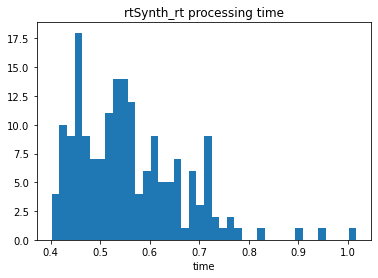

In [6]:
import numpy as np
import matplotlib.pyplot as plt
a=np.load("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/ses4/feedback/processedTime_14.npy")
plt.hist(a,bins=40)
plt.title("rtSynth_rt processing time")
plt.xlabel("time")

In [7]:
import pandas as pd
a=pd.read_csv("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002_backupAfterSes4/ses4/feedback/sub002_10_history.csv")
a

,TR,morphParam,states,points,B_prob,TR_milgram,timestamp
0,9,9,feedback,0,0.937379,8.0,1.621000e+09
1,10,9,feedback,0,0.808578,9.0,1.621000e+09
2,11,5,feedback,0,0.992583,10.0,1.621000e+09
3,12,5,feedback,0,0.671976,11.0,1.621000e+09
4,13,5,feedback,0,0.204961,12.0,1.621000e+09
5,23,13,feedback,0,0.044801,22.0,1.621000e+09
6,24,13,feedback,0,0.039180,23.0,1.621000e+09
7,25,13,feedback,0,0.139993,24.0,1.621000e+09
8,26,13,feedback,0,0.030399,25.0,1.621000e+09
9,27,13,feedback,0,0.047056,26.0,1.621000e+09


In [8]:
a=pd.read_csv("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/ses4/feedback/sub002_10_history.csv")
a

,TR,morphParam,states,points,B_prob,TR_milgram,timestamp
0,9,9,feedback,0,0.937379,8.0,1.621000e+09
1,10,9,feedback,0,0.808578,9.0,1.621000e+09
2,11,5,feedback,0,0.992583,10.0,1.621000e+09
3,12,5,feedback,0,0.671976,11.0,1.621000e+09
4,13,5,feedback,0,0.204961,12.0,1.621000e+09
5,23,13,feedback,0,0.044801,22.0,1.621000e+09
6,24,13,feedback,0,0.039180,23.0,1.621000e+09
7,25,13,feedback,0,0.139993,24.0,1.621000e+09
8,26,13,feedback,0,0.030399,25.0,1.621000e+09
9,27,13,feedback,0,0.047056,26.0,1.621000e+09


In [28]:
data=pd.read_csv("/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub002/ses4/feedback/sub002_10_history.csv")
B_prob = list(data["B_prob"])

threshold=0.9
suc_trial=0
while True:
    if len(B_prob)==0:
        break
    sucTR=0
    for i in range(5):
        if B_prob.pop(0)>threshold:
            sucTR+=1
    if sucTR>0:
        suc_trial+=1
suc_trial

6

In [26]:
len(B_prob)
B_prob.pop(0)
B_prob

[0.3598488492064438,
 0.09964943746028676,
 0.1960692056766191,
 0.9514048470201688,
 0.06032321416354881,
 0.2282822068813481,
 0.6512407276891512,
 0.007143859174536846,
 0.2991181251861992,
 0.15518467752338955,
 0.8253503619656254,
 0.09541831833153744,
 0.11294991598356224,
 0.3528240267324641,
 0.4121797970475704,
 0.9257716001180414,
 0.7822580798789179,
 0.7457955934868721,
 0.03835414652969592,
 0.6732081180946126,
 0.5828410479983004,
 0.05951659996038585,
 0.5718125811744516,
 0.0665678568450627,
 0.21085502595692232,
 0.3732545679294317,
 0.7499177635156951,
 0.2225387812100809,
 0.9649065797658064,
 0.08018410016601635,
 0.4465318352652768,
 0.045254221419546665,
 0.4007939232713668,
 0.8047440128658035,
 0.02894951231982758,
 0.9270347033090454,
 0.9508782126688564,
 0.5032727992396223,
 0.4755370119954477,
 0.7006076438431471,
 0.07288106080307488,
 0.05430971896395842,
 0.3185782959586642,
 0.9664311110566765,
 0.6780315059093125,
 0.6292997345056014,
 0.835489162748114

sub107
sub110
sub117
sub118
sub119
sub121
sub124
sub126
sub129
sub130
done


/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'progress trace mean for all subjects')

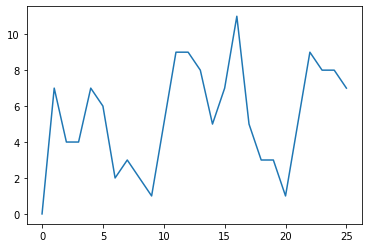

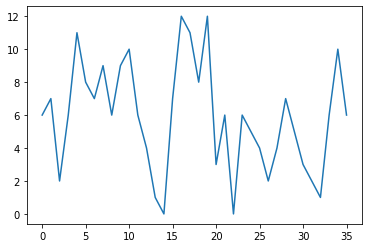

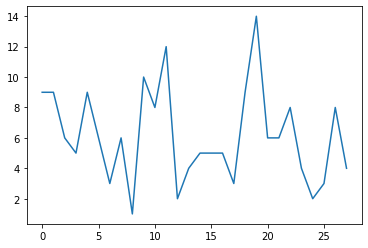

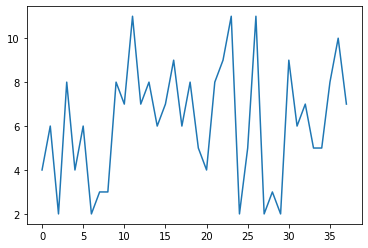

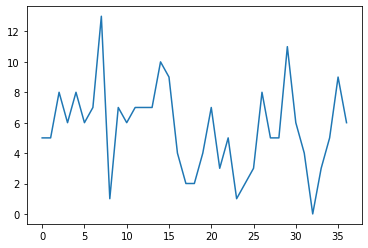

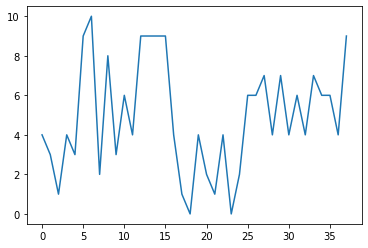

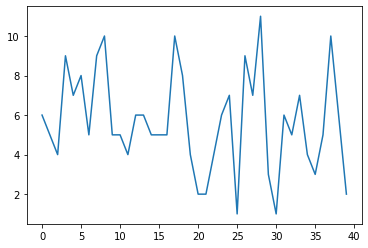

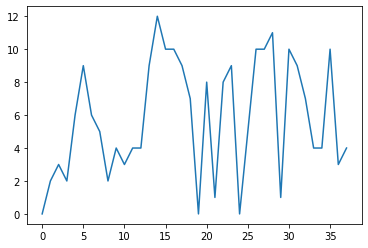

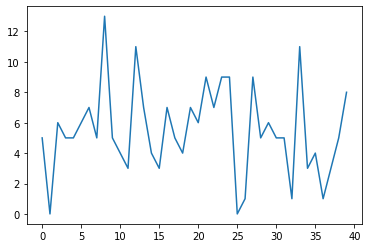

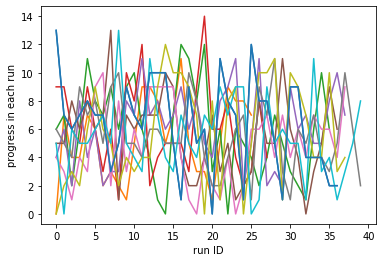

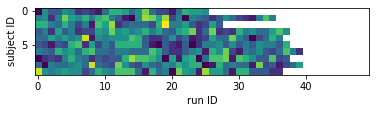

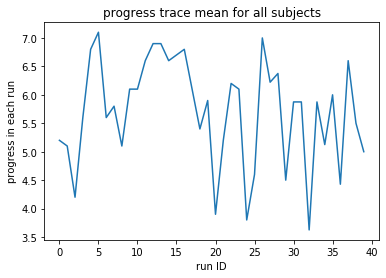

In [11]:

def AdaptiveThreshold(totalRunID,table,ignoreUnMatch): # totalRunID start from 0
    class MyStruct():
        def __init__(self):
            self.field1 = 1
    cfg=MyStruct()
    cfg.session = int(table.loc[totalRunID,"ses"])
    cfg.run = int(table.loc[totalRunID,"run"])

    table = table.loc[:totalRunID]
    table_curr_ses=table[table['ses']==cfg.session]
    ThresholdList = list(table['threshold'])[:-1]
    SuccessList = list(table_curr_ses["progress"])[:-1] #成功列表
    
    # 如果现在是第1个session的第一个feedback training run
    # threshold=0.6
    if cfg.session == 1 and cfg.run == 1:
        threshold=0.7

    # 如果现在是第N个session的第一个feedback training run
    # threshold=前一天的最后一个threshold
    elif cfg.run == 1:
        try:
            threshold=float(ThresholdList[-1])
        except:
            threshold=0.6 #在极端情况下，我可能第二个session没有能够运行feedback session，就必须在第三个session的时候的第一个run才产生第一个threshold
    else:
        change = 0
        threshold=float(ThresholdList[-1])

        # 如果之前的1个run的进步是<=1
        # threshold=threshold-5%
        if SuccessList[-1] <= 1:
            change = change - 0.05

        # 如果之前的1个run的进步全部>=11
        # threshold=threshold+5%
        if SuccessList[-1] >= 11:
            change = change + 0.05

        if len(SuccessList)>=3:
            # 如果之前的3个run的进步全部<=3
            # threshold=threshold-5%
            if SuccessList[-1] <= 3 and SuccessList[-2] <= 3 and SuccessList[-3] <= 3:
                change = change - 0.05

            # 如果之前的3个run的进步全部>=9
            # threshold=threshold+5%
            elif SuccessList[-1] >= 9 and SuccessList[-2] >= 9 and SuccessList[-3] >= 9:
                change = change + 0.05

        if len(SuccessList)>=5:
            # 如果之前的5个run的进步全部<=5
            # threshold=threshold-5%
            if SuccessList[-1] <= 5 and SuccessList[-2] <= 5 and SuccessList[-3] <= 5 and SuccessList[-4] <= 5 and SuccessList[-5] <= 5:
                change = change - 0.05

            # 如果之前的5个run的进步全部>=7
            # threshold=threshold+5%
            elif SuccessList[-1] >= 7 and SuccessList[-2] >= 7 and SuccessList[-3] >= 7 and SuccessList[-4] >= 7 and SuccessList[-5] >= 7:
                change = change + 0.05
        # 如果之前的任意个run的进步全部【6】
        # threshold=threshold
        if SuccessList[-1] == 6:
            change = 0

        if change > 0.05:
            change = 0.05
        if change < -0.05:
            change = -0.05
        threshold = threshold + change

    # 不要越界
    if threshold>0.9:
        threshold=0.9
    if threshold<0.4:
        threshold=0.4

    # 如果这个run已经跑过了，给出这个error提醒。
    if len(table[(table['ses']==cfg.session) & (table['run']==cfg.run)])>1: #more robust than     # if ThresholdLog['session'].iloc[-1]==cfg.session and ThresholdLog['run'].iloc[-1]==cfg.run:
        print(f"this run exists!")
        raise Exception(f"this run exists!") 
    # print(f"threshold={threshold}")
    # print(f"float(table.loc[totalRunID,'threshold'])={float(table.loc[totalRunID,'threshold'])}")
    if float(round(threshold,2)) != float(table.loc[totalRunID,"threshold"]):
        if ignoreUnMatch<=0:
            assert  float(round(threshold,2)) == float(table.loc[totalRunID,"threshold"])
        else:
            ignoreUnMatch-=1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data=pd.read_csv("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/realtime/experiment/catalin_data_for_adaptive_thresold.csv")
data=data[["sub","ses","run","threshold","progress"]]
data=data.dropna()
# data.iloc[-50:]
subjects = np.unique(list(data['sub']))
ignoreUnMatch=1 # found one mismatch, ignore this
performance=[]
for sub in subjects:
    print(sub)
    table = data[data["sub"]==sub]
    table=table.reset_index()
    plt.figure()
    t=list(table['progress'])
    performance.append(t)
    _=plt.plot(t)
    for totalRunID in range(len(table)):
        AdaptiveThreshold(totalRunID,table,ignoreUnMatch)
print("done")

# plot all traces
performances=np.zeros((10,50))
performances[performances==0]=None
for i,sub in enumerate(performance):
    plt.plot(sub)
    performances[i,0:len(sub)]=sub
plt.xlabel("run ID")
plt.ylabel("progress in each run")

    
plt.figure()
plt.xlabel("run ID")
plt.ylabel("subject ID")

plt.imshow(performances)

plt.figure()
plt.plot(np.nanmean(performances,axis=0))
plt.xlabel("run ID")
plt.ylabel("progress in each run")
plt.title("progress trace mean for all subjects")